# Self-Organizing Map

In [22]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select
from src.utils.distributed_silhouette import DistributedSilhouette

import json

In [23]:
connection = connect_to_spotify_dataset() # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [24]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,73gfHKufFmtlEBfPhfXrca,Soy Esclavo de Tu Cuerpo,44,195571,False,"[Yampi, Anuel AA]","[3Ia6QnB1tPR9bcgnmbL5FO, 2R21vXR83lH98kGeO99Y66]",2014-02-28,0.705,0.660,...,0.020200,0.0885,0.484,89.980,4,2010,0.5855,1.6198,0.6825,0.40360
1,4DN86kfq76ltzhRt0Zbfh7,Despídete con Un Beso,40,249289,False,[Buddy Richard],[6qSkZrS7Xdje9DVRXlNmpE],2014-01-01,0.520,0.577,...,0.000123,0.1500,0.866,121.070,4,2010,0.7044,3.1847,0.5485,0.36000
2,6Ubz6F0BwkiSk0b1qfXUjl,Creo en Ti,42,240568,False,"[Ana Tijoux, Juanito Ayala]","[40JMTpVRUw90SrN4pFA6Mz, 4Wy8CFlIS11ODC9wVKBSz4]",2014-04-15,0.746,0.578,...,0.000017,0.1450,0.674,91.984,4,2010,0.6764,2.6396,0.6620,0.20474
3,0HqtzBaZpjoEZ84WbbEcoe,Fumo Marihuana,47,213861,True,"[Morodo, Heavy Roots]","[2OnH4HpywAxWkSOEsyjdjn, 4fEogLHgLSsp5ETlJCci09]",2014-10-06,0.797,0.780,...,0.000000,0.2860,0.890,127.946,4,2010,0.8401,1.7414,0.7885,0.37000
4,35TRct8Yqqmy0XUPg8UFbn,Nabundearé,39,175413,False,[Nicole Bunout],[5jyOjqLd2YRArrVlguvv4F],2014,0.433,0.387,...,0.000010,0.1200,0.229,102.648,4,2010,0.3218,3.2686,0.4100,0.65560


# Feature Engineering

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

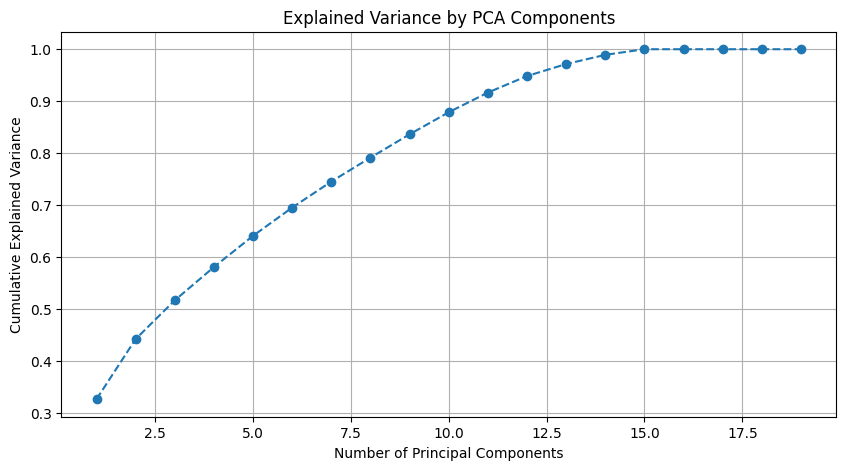

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [27]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [28]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-1.923608,0.216815,1.429029,-0.749358,1.100143,-1.545046,0.862412,0.064454,-0.120919,-0.794141,-0.171781,-1.348370,-0.095211
1,-1.263122,-0.033584,-0.293471,-0.351204,-1.452548,0.606364,0.050187,0.399452,-0.575364,0.026094,0.540956,0.396765,-0.554652
2,-2.239276,-0.116359,1.095530,-0.745712,0.529153,0.235887,0.961824,0.043867,-1.175079,-0.643796,-0.172470,-0.066089,0.007920
3,-3.684049,-0.696342,1.990822,-0.579600,-1.665418,0.639042,-0.602535,-2.670167,1.494730,2.260642,1.103821,0.619691,0.074873
4,1.282279,1.743053,1.140887,-0.860555,0.981311,-2.108115,-0.017262,0.257688,-0.172775,-0.842064,0.330861,-0.109839,0.188596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,-3.980816,-0.024021,0.394329,-0.566020,1.235697,-0.054074,1.124274,0.129074,-0.566942,-0.413023,0.035124,-0.124795,0.426075
525583,-3.064142,-0.010076,0.329434,0.132774,-0.256038,-0.231712,1.074822,0.704844,0.694258,-0.159269,-0.385363,-0.970065,-0.612428
525584,-2.045791,-2.076199,-2.672694,0.595499,-0.712938,0.251151,0.123267,-0.778775,0.174060,0.811836,-1.342184,0.549542,-1.375136
525585,-0.770571,0.040217,-0.297150,-1.438698,0.489357,-1.898590,-1.826702,0.095577,-1.189166,0.723768,0.959096,-0.994316,0.090137


### Model Training

In [ ]:
from minisom import MiniSom

In [ ]:
# MiniSom Clustering Model
grid_sizes = [[10,10],[25,25],[50,50],[100,100]]
for x,y in grid_sizes:
    
    grid_x, grid_y = x,y

    # Initialize SOM
    som = MiniSom(grid_x, grid_y, 13, sigma=1.0, learning_rate=0.3)
    som.random_weights_init(X_pca_final)

    # Train SOM
    som.train_random(X_pca_final,100000)

    # Assign each data point to its Best Matching Unit (BMU)
    bmu_indices = np.array([som.winner(x) for x in X_pca_final])

    # Convert BMU indices to cluster labels
    cluster_labels = np.array([x * grid_y + y for x, y in bmu_indices])

    # Compute Sum of squared Euclidean distances to BMUs
    bmu_weights = np.array([som.get_weights()[x, y] for x, y in bmu_indices])
    inertia = np.sum(np.linalg.norm(X_pca_final - bmu_weights, axis=1) ** 2)
    
    # Compute Quantization Error (average Euclidean distance to BMUs)
    quantization_error = np.mean(np.linalg.norm(X_pca_final - bmu_weights, axis=1))
    # create the grid
    plt.figure(figsize=(8, 8))
    #plot the distance map
    plt.pcolor(som.distance_map().T) 
    # show the color bar
    plt.colorbar()
    plt.show()

    print(f"Grid Size: {grid_x}x{grid_y} - Inertia: {inertia:.4f}, Quantization Error: {quantization_error:.4f}")

In [ ]:
neighborhood_functions = ['gaussian', 'mexican_hat', 'bubble', 'triangle']
activation_distance = ['euclidean', 'cosine', 'manhattan', 'chebyshev']
lowest_inertia = float('inf')
best_som = None
for i in range(4):
    for j in range(4):
        som = MiniSom(100, 100, 13, sigma=1.0, learning_rate=0.3,neighborhood_function=neighborhood_functions[i],activation_distance=activation_distance[j])
        
        som.random_weights_init(X_pca_final)
        
        som.train_random(X_pca_final,525587) # One iteration per Sample

        bmu_indices = np.array([som.winner(x) for x in X_pca_final])
        bmu_weights = np.array([som.get_weights()[x, y] for x, y in bmu_indices])
        
        inertia = np.sum(np.linalg.norm(X_pca_final - bmu_weights, axis=1) ** 2)
        print(f"n_func: {neighborhood_functions[i]} a_distance: {activation_distance[j]} inertia: {inertia}")

        if inertia < lowest_inertia:
            best_som = som
            inertia = lowest_inertia
som = best_som

In [ ]:
som = MiniSom(100, 100, 13, sigma=1.0, learning_rate=0.3,neighborhood_function='triangle',activation_distance='euclidean')
som.random_weights_init(X_pca_final)
som.train_random(X_pca_final,525587)

In [ ]:
from collections import Counter

bmus = [tuple(som.winner(d)) for d in X_pca_final]
bmu_counts = Counter(bmus)

hit_map = np.zeros((100, 100))
for (x, y), count in bmu_counts.items():
    hit_map[x, y] = count

# Hit Map
plt.figure(figsize=(10, 10))
plt.imshow(hit_map, cmap='coolwarm', origin='upper')
plt.colorbar(label="Number of Hits")
plt.title("SOM Hit Map")
plt.show()

In [ ]:
df['bmu'] = bmus
df['bmu'] = df['bmu'].apply(list)
df.head()

In [ ]:
df.to_json("bmu_data.json", orient="records", indent=4)

### Playlist Generation

In [10]:
with open("bmu_data.json", "r") as f:
    cluster_labels = json.load(f)
labels_array = bmu_array = np.array([entry['bmu'] for entry in cluster_labels]) 

bmu_tuples = [tuple(bmu) for bmu in labels_array]  # Convert to list of tuples

In [11]:
bmu_df = df[['id','name','artists']]
bmu_df['bmu_x'] = [b[0] for b in bmu_tuples]
bmu_df['bmu_y'] = [b[1] for b in bmu_tuples]

def generate_playlist(df, song_id):
    selected_song = df[df["id"] == song_id]

    # Calculate Euclidean distance from the selected song's BMU
    df["distance"] = np.sqrt((df["bmu_x"] - selected_song["bmu_x"])**2 +
                             (df["bmu_y"] - selected_song["bmu_y"])**2)
    
    # Get the 15 most similar songs (excluding the selected song)
    similar_songs = df.sort_values(by="distance")[1:16]

    # Format the playlist
    playlist = {
        "Selected Song": {
            "song_name": selected_song["name"],
            "artist": selected_song["artists"]
        },
        "Recommended Songs": similar_songs[["name", "artists"]].to_dict(orient="records")
    }

    return playlist

# Generate and print a playlist
playlist = generate_playlist(bmu_df,'047fCsbO4NdmwCBn8pcUXl')
print(playlist)

/var/folders/qc/c98b3cz16bdfd88s6hww6clm0000gn/T/ipykernel_16593/1255678675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmu_df['bmu_x'] = [b[0] for b in bmu_tuples]


{'Selected Song': {'song_name': 90170    Marvins Room
Name: name, dtype: object, 'artist': 90170    [Drake]
Name: artists, dtype: object}, 'Recommended Songs': [{'name': 'Soy Esclavo de Tu Cuerpo', 'artists': ['Yampi', 'Anuel AA']}, {'name': 'Despídete con Un Beso', 'artists': ['Buddy Richard']}, {'name': 'Creo en Ti', 'artists': ['Ana Tijoux', 'Juanito Ayala']}, {'name': 'Fumo Marihuana', 'artists': ['Morodo', 'Heavy Roots']}, {'name': 'Nabundearé', 'artists': ['Nicole Bunout']}, {'name': 'Suena Cabrrr (feat. Kendo Kaponi & Dy)', 'artists': ['Los De La Nazza', 'Kendo Kaponi', 'DY']}, {'name': 'Cantando Voy', 'artists': ['Apache', 'Movimiento Original']}, {'name': 'La Granja de Mis Abuelos', 'artists': ['Cantando Aprendo a Hablar']}, {'name': 'Piel Morena', 'artists': ['Megapuesta']}, {'name': 'Nadie', 'artists': ['Los Rancheros De Rio Maule']}, {'name': 'Peligro, Cap. 4', 'artists': ['Cosculluela', 'Kendo Kaponi', 'Jungl', 'Mueka']}, {'name': 'En Todo Estaré', 'artists': ['Chayanne']

/var/folders/qc/c98b3cz16bdfd88s6hww6clm0000gn/T/ipykernel_16593/1255678675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmu_df['bmu_y'] = [b[1] for b in bmu_tuples]
/var/folders/qc/c98b3cz16bdfd88s6hww6clm0000gn/T/ipykernel_16593/1255678675.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = np.sqrt((df["bmu_x"] - selected_song["bmu_x"])**2 +


In [36]:
def get_songs_from_bmu(df, bmu_x, bmu_y, min_songs=10, max_songs=15):

    filtered_songs = df[(df['bmu_x'] == bmu_x) & (df['bmu_y'] == bmu_y)]

    num_songs = len(filtered_songs)

    if num_songs < min_songs:
        repeats_needed = min_songs - num_songs
        additional_songs = filtered_songs.sample(repeats_needed, replace=True, random_state=42)
        filtered_songs = pd.concat([filtered_songs, additional_songs])

    return filtered_songs.sample(min(max_songs, len(filtered_songs)), random_state=42)

# Find the BMU with the most and least hits
bmu_counts = bmu_df.groupby(['bmu_x', 'bmu_y']).size().reset_index(name='count')

## Example set of Songs from 1 BMU
get_songs_from_bmu(bmu_df,13,63)

,id,name,artists,bmu_x,bmu_y,distance
426943,3DlmXXD7OkG4wQlG9T303U,Somebody Touched Me,[Ruth Brown],13,63,NaN
180282,4Wg6Ggb6DY8OmlFQvvHO9b,Gavilán o Paloma,[José José],13,63,NaN
232119,7FFQsnjzumC6eyCXRFPQ2f,What Am I Gonna Do,[Tyrese],13,63,NaN
15853,29I9v8TegMNqf302jJMXcy,Paul der Hooligan,[Broilers],13,63,NaN
403950,0sP8L42NvkB95hkiN5kFPg,Beira-Mar,[Zé Ramalho],13,63,NaN
181387,4JqusF4byBFBfcv43ZPyjc,Talking In Your Sleep,[Crystal Gayle],13,63,NaN
486231,2nV9mYewNu9cdHZGcLUHMU,¿Quién Te Robó El Corazón?,[Los Askis],13,63,NaN
206067,05MHAyxtazO0FYIMYREG6O,Un Viaje Largo,[Marcela Gandara],13,63,NaN
181597,3FJzoDaMsDjHxdM4vjJJdJ,Funky Bitch,[Son Seals],13,63,NaN
335399,7gZQm8KRpT8hQAjLES0Ty2,Llevame al Disco,[Fabulas Aticas],13,63,NaN


In [31]:
bmu_counts[bmu_counts['count'] ==10]

,bmu_x,bmu_y,count
218,2,18,10
510,5,10,10
637,6,37,10
768,7,68,10
819,8,19,10
867,8,67,10
1363,13,63,10
1366,13,66,10
1492,14,92,10
1535,15,35,10
